In [1]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix, classification_report
import time

Facial emotion recognition is an exciting and important area of artificial intelligence that focuses on understanding human emotions through facial expressions. Our faces naturally reveal what we feel—whether it's happiness, sadness, anger, or surprise. Teaching machines to recognize these emotions can have a big impact on various fields, such as mental health monitoring, human-computer interaction, security systems, and even customer service. By training deep learning models on facial expressions, we can create systems that understand and respond to human emotions more effectively.

In [2]:
# https://www.kaggle.com/datasets/msambare/fer2013
path_fer2013 = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path_fer2013)

# https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
path_affectnet = kagglehub.dataset_download("noamsegal/affectnet-training-data")

print("Path to dataset files:", path_affectnet)


100%|██████████| 60.3M/60.3M [00:00<00:00, 204MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


100%|██████████| 314M/314M [00:01<00:00, 166MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3


To train an accurate emotion recognition model, we need a large and diverse dataset that contains images of people expressing different emotions. The FER2013 [1], [3] dataset is widely used in facial emotion recognition research. It consists of 35,887 grayscale images categorized into seven emotions: Angry, Disgust, Fear, Happy, Neutral, Sad, and Surprise. This dataset is useful because it provides a variety of facial expressions from different individuals, captured in real-world conditions.

However, FER2013 has some limitations, such as lower image quality and imbalanced data distribution. To overcome these challenges and improve model performance, I also included the AffectNet dataset. AffectNet [2], [4] is one of the largest facial expression datasets available, containing over 400,000 images collected from the internet. It provides more diverse facial expressions, better image quality, and a broader range of emotions.

In [3]:
# Path to the FER2013 dataset
fer_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"

# List all files in the FER2013 dataset directory
fer_files = os.listdir(fer_path)

# Display the first 10 files to check the dataset structure
print("Contents of FER2013:", fer_files[:10])


# Path to the RAF-DB dataset
affectnet_path = "/root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3"

# List all files in the Affectnet dataset directory
affectnet_files = os.listdir(affectnet_path)

# Display the first 10 files to check the dataset structure
print("Contents of Affectnet:", affectnet_files[:10])


Contents of FER2013: ['test', 'train']
Contents of Affectnet: ['happy', 'neutral', 'anger', 'sad', 'contempt', 'surprise', 'disgust', 'fear', 'labels.csv']


In [4]:
fer_train_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train/"
fer_test_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test/"

print("FER2013 Train Subfolders:", os.listdir(fer_train_path))
print("FER2013 Test Subfolders:", os.listdir(fer_test_path))

FER2013 Train Subfolders: ['happy', 'neutral', 'sad', 'surprise', 'disgust', 'fear', 'angry']
FER2013 Test Subfolders: ['happy', 'neutral', 'sad', 'surprise', 'disgust', 'fear', 'angry']


In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to match FER2013 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset paths
fer_train_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train/"
fer_test_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test/"
affectnet_path = "/root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/3/"

# Remove the "contempt" folder from AffectNet before loading
contempt_path = os.path.join(affectnet_path, "contempt")
if os.path.exists(contempt_path):
    print("Removing 'contempt' from AffectNet dataset...")
    import shutil
    shutil.rmtree(contempt_path)  # Delete the folder


Removing 'contempt' from AffectNet dataset...


AffectNet originally includes eight emotions: Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise, and Contempt. However, FER2013 does not include the "Contempt" emotion, meaning that if I kept it in my dataset, it could create inconsistencies during training. Since my goal was to train a model that works well across both datasets, I decided to remove "Contempt" from AffectNet to keep the label distribution consistent.

In [6]:
# Load FER2013 dataset
fer_train_dataset = datasets.ImageFolder(root=fer_train_path, transform=transform)
fer_test_dataset = datasets.ImageFolder(root=fer_test_path, transform=transform)

# Load AffectNet dataset (without "contempt")
affectnet_dataset = datasets.ImageFolder(root=affectnet_path, transform=transform)


In [7]:
# Get class mappings
print("FER2013 Classes:", fer_train_dataset.classes)  # ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("AffectNet Classes:", affectnet_dataset.classes)  # ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Label mapping for AffectNet to match FER2013
affectnet_label_map = {
    affectnet_dataset.class_to_idx["anger"]: fer_train_dataset.class_to_idx["angry"],  # Rename "anger" → "angry"
    affectnet_dataset.class_to_idx["disgust"]: fer_train_dataset.class_to_idx["disgust"],
    affectnet_dataset.class_to_idx["fear"]: fer_train_dataset.class_to_idx["fear"],
    affectnet_dataset.class_to_idx["happy"]: fer_train_dataset.class_to_idx["happy"],
    affectnet_dataset.class_to_idx["neutral"]: fer_train_dataset.class_to_idx["neutral"],
    affectnet_dataset.class_to_idx["sad"]: fer_train_dataset.class_to_idx["sad"],
    affectnet_dataset.class_to_idx["surprise"]: fer_train_dataset.class_to_idx["surprise"],
}

# New dataset with the correct labels
class RenamedAffectNetDataset(Dataset):
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = label_map

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        new_label = self.label_map[label]  # Apply the corrected label mapping
        return image, new_label

# Apply the corrected labels
affectnet_dataset = RenamedAffectNetDataset(affectnet_dataset, affectnet_label_map)


FER2013 Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
AffectNet Classes: ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
# Split AffectNet dataset into 80% training and 20% validation
train_size = int(0.8 * len(affectnet_dataset))
val_size = len(affectnet_dataset) - train_size
affectnet_train, affectnet_val = random_split(affectnet_dataset, [train_size, val_size])


In [9]:
# Merge train, validation, and test datasets
combined_train_dataset = ConcatDataset([fer_train_dataset, affectnet_train])
combined_val_dataset = ConcatDataset([fer_test_dataset, affectnet_val])
combined_test_dataset = fer_test_dataset

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)


By combining FER2013 and AffectNet, I ensured that my model learns from a richer dataset, which helps improve its ability to generalize across different faces, lighting conditions, and real-world variations.

Total images in Train set: 49645
Total images in Validation set: 12413
Total images in Test set: 7178


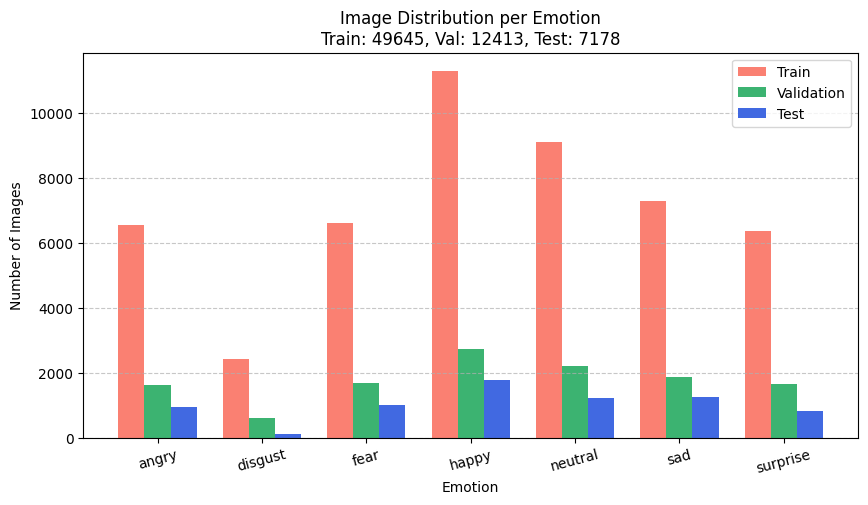

In [10]:
# Emotion labels (matching FER2013)
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Function to count images per class
def count_labels(dataset):
    counts = {i: 0 for i in range(len(emotions))}
    for _, label in dataset:
        counts[label] += 1
    return counts

# Count images per emotion
train_counts = count_labels(combined_train_dataset)
val_counts = count_labels(combined_val_dataset)
test_counts = count_labels(combined_test_dataset)

# Convert counts to lists (matching emotions order)
train_values = [train_counts[i] for i in range(len(emotions))]
val_values = [val_counts[i] for i in range(len(emotions))]
test_values = [test_counts[i] for i in range(len(emotions))]

# Total images per dataset
total_train = sum(train_values)
total_val = sum(val_values)
total_test = sum(test_values)

print(f"Total images in Train set: {total_train}")
print(f"Total images in Validation set: {total_val}")
print(f"Total images in Test set: {total_test}")

bar_width = 0.25
x = np.arange(len(emotions))

plt.figure(figsize=(10, 5))

plt.bar(x - bar_width, train_values, width=bar_width, label="Train", color="salmon")
plt.bar(x, val_values, width=bar_width, label="Validation", color="mediumseagreen")
plt.bar(x + bar_width, test_values, width=bar_width, label="Test", color="royalblue")

plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(ticks=x, labels=emotions, rotation=15)
plt.title("Image Distribution per Emotion")
plt.legend()

plt.title(f"Image Distribution per Emotion\nTrain: {total_train}, Val: {total_val}, Test: {total_test}")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


The dataset is divided into three sets to ensure effective model training and evaluation. The training set consists of 49,645 images, which is the largest portion, allowing the model to learn facial expression patterns. The validation set contains 12,413 images, helping to fine-tune the model and prevent overfitting. Finally, the test set includes 7,178 images, used to evaluate the model’s performance on unseen data.

The graph visually represents the number of images available for each emotion across the train, validation, and test datasets. The x-axis shows the seven emotions: angry, disgust, fear, happy, neutral, sad, and surprise, while the y-axis represents the number of images.

One key observation is that the "happy" emotion has the highest number of images in all three datasets. This suggests that happy faces are more commonly available in facial expression datasets, which might make it easier for the model to recognize happiness accurately. On the other hand, the "disgust" category has the least number of images, meaning it is underrepresented. This imbalance could make it harder for the model to correctly classify disgust compared to other emotions.

Another important aspect is that the distribution of emotions across the training, validation, and test sets is relatively consistent. This means that the ratio of each emotion remains balanced across different phases of model development. Such a distribution helps the model generalize better and ensures that no single emotion is overrepresented in the validation or test sets.

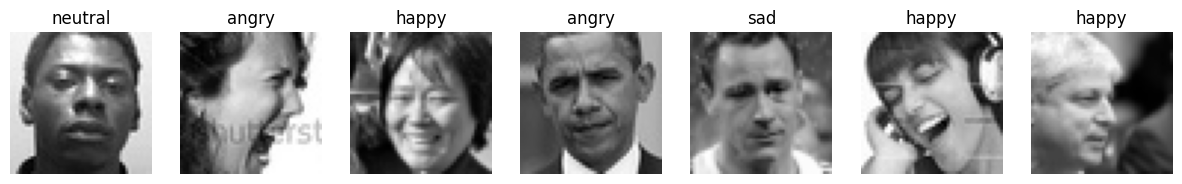

In [11]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Function to display random images with labels
def show_random_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Select a random index
        idx = random.randint(0, len(dataset) - 1)

        # Get image and label
        image, label = dataset[idx]

        # Convert image tensor to numpy array
        image = image.squeeze().numpy()  # Remove single dimension (for grayscale)

        axes[i].imshow(image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(emotions[label])

    plt.show()

show_random_images(combined_train_dataset, num_images=7)


In [12]:
class DeepEmotionCNN(nn.Module):
    def __init__(self):
        super(DeepEmotionCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # Reduce size by half
        self.dropout1 = nn.Dropout(0.2)  # Dropout after first block

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)  # Dropout after second block

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)  # Dropout after third block

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 6 * 6, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 7)  # 7 emotion classes

    def forward(self, x):
        """
        Forward pass:
        - Apply convolutional blocks with ReLU, batch normalization, dropout, and max pooling
        - Flatten the feature maps
        - Apply fully connected layers with dropout
        - Output the final class scores (logits)
        """

        # Convolutional Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)  # Apply dropout

        # Convolutional Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)  # Apply dropout

        # Convolutional Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)  # Apply dropout

        # Flatten feature maps
        x = x.view(-1, 512 * 6 * 6)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)  # Apply dropout
        x = self.fc3(x)  # No softmax, as it's included in CrossEntropyLoss

        return x

# Initialize the model and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_DeepEmotionCNN = DeepEmotionCNN().to(device)

print(model_DeepEmotionCNN)

criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model_DeepEmotionCNN.parameters(), lr=0.001)

# Optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model_DeepEmotionCNN.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning rate scheduler (Reduce LR when validation loss stops improving)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Lower LR (0.0005) → More stable updates
# Weight decay (1e-4) → Prevents overfitting
# Scheduler → Adjusts learning rate when loss stops improving



DeepEmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


The DeepEmotionCNN model is a deep convolutional neural network (CNN) designed for facial emotion recognition. It consists of three convolutional blocks, each containing two convolutional layers followed by batch normalization, ReLU activation, max pooling, and dropout to prevent overfitting. As the network progresses, the number of filters increases, allowing the model to capture more complex facial features. After feature extraction, the network flattens the output and passes it through three fully connected layers with additional dropout for regularization. The final layer outputs predictions for seven emotion classes. The model is trained using CrossEntropyLoss, optimized with Adam (learning rate = 0.0005, weight decay = 1e-4) for stable learning, and includes a learning rate scheduler to reduce the LR when validation loss stops improving. These optimizations help enhance performance and prevent overfitting.

Model saved at epoch 1 with Val Acc: 22.03%
Epoch [1/30] - Train Loss: 1.8732, Train Acc: 21.96% - Val Loss: 1.7648, Val Acc: 22.03%


Model saved at epoch 2 with Val Acc: 33.27%
Epoch [2/30] - Train Loss: 1.7510, Train Acc: 23.61% - Val Loss: 1.6779, Val Acc: 33.27%


Model saved at epoch 3 with Val Acc: 37.25%
Epoch [3/30] - Train Loss: 1.6409, Train Acc: 31.97% - Val Loss: 1.5679, Val Acc: 37.25%


Model saved at epoch 4 with Val Acc: 42.31%
Epoch [4/30] - Train Loss: 1.5927, Train Acc: 34.16% - Val Loss: 1.5664, Val Acc: 42.31%


Model saved at epoch 5 with Val Acc: 44.80%
Epoch [5/30] - Train Loss: 1.5171, Train Acc: 38.98% - Val Loss: 1.4635, Val Acc: 44.80%


Model saved at epoch 6 with Val Acc: 47.97%
Epoch [6/30] - Train Loss: 1.4750, Train Acc: 40.54% - Val Loss: 1.3977, Val Acc: 47.97%


Epoch [7/30] - Train Loss: 1.4293, Train Acc: 42.86% - Val Loss: 1.3738, Val Acc: 47.90%


Model saved at epoch 8 with Val Acc: 50.30%
Epoch [8/30] - Train Loss: 1.3499, Train Acc: 46.60% - Val Loss: 1.2976, Val Acc: 50.30%


Model saved at epoch 9 with Val Acc: 52.46%
Epoch [9/30] - Train Loss: 1.2774, Train Acc: 50.00% - Val Loss: 1.2690, Val Acc: 52.46%


Epoch [10/30] - Train Loss: 1.2201, Train Acc: 51.84% - Val Loss: 1.2658, Val Acc: 51.51%


Model saved at epoch 11 with Val Acc: 53.90%
Epoch [11/30] - Train Loss: 1.1747, Train Acc: 53.59% - Val Loss: 1.1894, Val Acc: 53.90%


Model saved at epoch 12 with Val Acc: 55.93%
Epoch [12/30] - Train Loss: 1.1263, Train Acc: 55.38% - Val Loss: 1.1391, Val Acc: 55.93%


Model saved at epoch 13 with Val Acc: 57.67%
Epoch [13/30] - Train Loss: 1.0905, Train Acc: 57.45% - Val Loss: 1.1111, Val Acc: 57.67%


Epoch [14/30] - Train Loss: 1.0529, Train Acc: 59.23% - Val Loss: 1.0744, Val Acc: 57.26%


Model saved at epoch 15 with Val Acc: 59.79%
Epoch [15/30] - Train Loss: 1.0222, Train Acc: 60.84% - Val Loss: 1.0667, Val Acc: 59.79%


Epoch [16/30] - Train Loss: 0.9892, Train Acc: 62.24% - Val Loss: 1.0446, Val Acc: 59.70%


Model saved at epoch 17 with Val Acc: 62.43%
Epoch [17/30] - Train Loss: 0.9584, Train Acc: 63.48% - Val Loss: 0.9992, Val Acc: 62.43%


Model saved at epoch 18 with Val Acc: 62.83%
Epoch [18/30] - Train Loss: 0.9217, Train Acc: 65.24% - Val Loss: 0.9889, Val Acc: 62.83%


Epoch [19/30] - Train Loss: 0.8874, Train Acc: 66.43% - Val Loss: 0.9887, Val Acc: 62.27%


Model saved at epoch 20 with Val Acc: 63.49%
Epoch [20/30] - Train Loss: 0.8630, Train Acc: 67.41% - Val Loss: 0.9643, Val Acc: 63.49%


Model saved at epoch 21 with Val Acc: 64.82%
Epoch [21/30] - Train Loss: 0.8249, Train Acc: 69.13% - Val Loss: 0.9355, Val Acc: 64.82%


Epoch [22/30] - Train Loss: 0.7925, Train Acc: 70.37% - Val Loss: 0.9519, Val Acc: 62.90%


Model saved at epoch 23 with Val Acc: 64.92%
Epoch [23/30] - Train Loss: 0.7599, Train Acc: 71.82% - Val Loss: 0.9309, Val Acc: 64.92%


Epoch [24/30] - Train Loss: 0.7219, Train Acc: 73.20% - Val Loss: 0.9400, Val Acc: 63.64%


Model saved at epoch 25 with Val Acc: 66.08%
Epoch [25/30] - Train Loss: 0.6923, Train Acc: 74.17% - Val Loss: 0.9323, Val Acc: 66.08%


Model saved at epoch 26 with Val Acc: 66.30%
Epoch [26/30] - Train Loss: 0.6566, Train Acc: 75.59% - Val Loss: 0.9236, Val Acc: 66.30%


Epoch [27/30] - Train Loss: 0.6314, Train Acc: 76.88% - Val Loss: 0.9419, Val Acc: 65.99%


Epoch [28/30] - Train Loss: 0.6040, Train Acc: 77.87% - Val Loss: 0.9781, Val Acc: 65.76%


Epoch [29/30] - Train Loss: 0.5795, Train Acc: 78.67% - Val Loss: 0.9768, Val Acc: 66.11%


Model saved at epoch 30 with Val Acc: 66.70%
Epoch [30/30] - Train Loss: 0.5516, Train Acc: 79.86% - Val Loss: 0.9638, Val Acc: 66.70%
Training completed!
Total training time: 0h 37m 49s


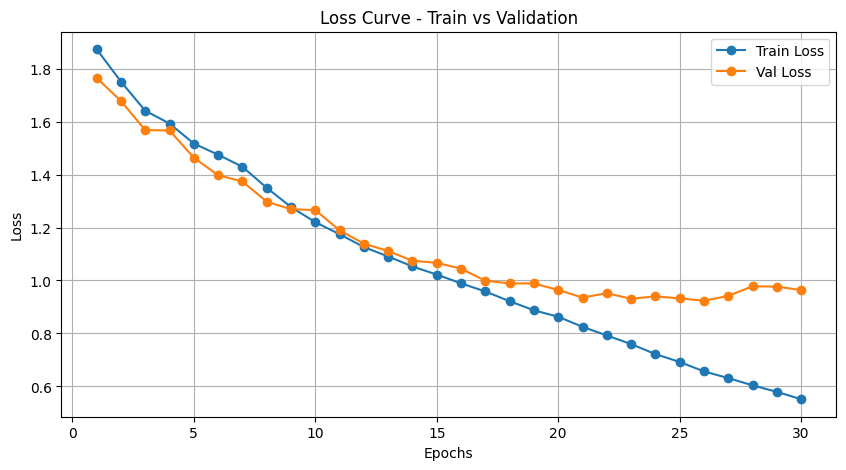

In [13]:
start_time = time.time()

# Training parameters
EPOCHS = 30
best_val_acc = 0.0  # Variable to track the best validation accuracy

train_losses, val_losses = [], []

# Training loop
for epoch in range(EPOCHS):
    model_DeepEmotionCNN.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_DeepEmotionCNN(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_loader_tqdm.set_postfix(loss=loss.item(), acc=100 * correct / total)

    # Compute average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)

    # Validation phase
    model_DeepEmotionCNN.eval()  # Set model to evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_DeepEmotionCNN(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)

    # Reduce learning rate if validation loss stops improving
    scheduler.step(val_loss)

    # Save the model if it achieves the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc  # Update the best accuracy
        torch.save(model_DeepEmotionCNN.state_dict(), "best_model.pth")  # Save model
        print(f"Model saved at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")

    print(f"Epoch [{epoch+1}/{EPOCHS}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Training completed!")

end_time = time.time()

# Total time taken for training
total_time = end_time - start_time

# Convert time to hours, minutes, and seconds
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print(f"Total training time: {hours}h {minutes}m {seconds}s")

plt.figure(figsize=(10,5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve - Train vs Validation")
plt.grid()
plt.show()


This graph represents the loss curve for both the training and validation sets over 30 epochs. The blue line shows the training loss, which steadily decreases, indicating that the model is learning and improving on the training data. The orange line represents the validation loss, which also decreases initially but starts to plateau around epoch 15–20 and slightly fluctuates afterward.

A key observation is that while training loss keeps decreasing, validation loss stops improving significantly and even increases slightly after epoch 20, suggesting possible overfitting—the model is memorizing the training data rather than generalizing well to unseen data.

Test Accuracy: 65.45%


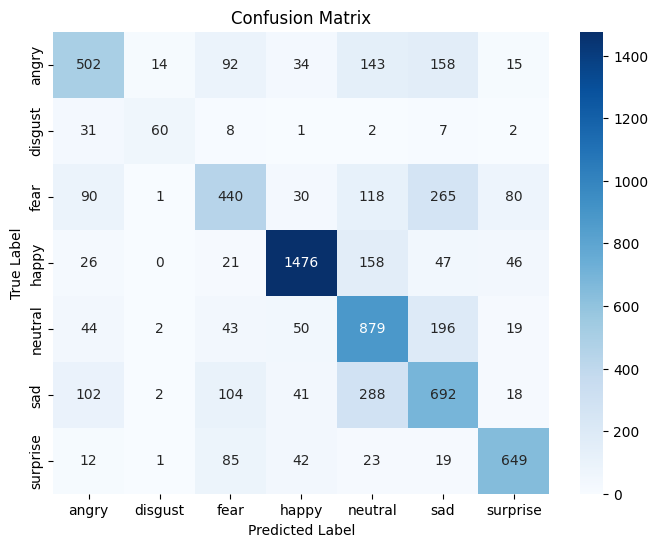


Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.52      0.57       958
     disgust       0.75      0.54      0.63       111
        fear       0.55      0.43      0.48      1024
       happy       0.88      0.83      0.86      1774
     neutral       0.55      0.71      0.62      1233
         sad       0.50      0.55      0.53      1247
    surprise       0.78      0.78      0.78       831

    accuracy                           0.65      7178
   macro avg       0.66      0.63      0.64      7178
weighted avg       0.66      0.65      0.65      7178



In [14]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

all_true_labels = []
all_predicted_labels = []

# Set model to evaluation mode
model_DeepEmotionCNN.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_DeepEmotionCNN(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices

        # Append true and predicted labels
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Compute test accuracy
test_acc = 100 * np.sum(np.array(all_predicted_labels) == np.array(all_true_labels)) / len(all_true_labels)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))


The model achieved a test accuracy of 65.45%, indicating a moderate ability to classify facial expressions correctly. The confusion matrix provides insight into how well the model predicts each emotion. While it performs well on certain emotions like happy (1476 correct predictions) and surprise (649 correct predictions), it struggles with others like fear and disgust, where misclassifications are more frequent. This suggests that the model finds it harder to distinguish between emotions that share similar facial features.

The classification report gives a deeper breakdown of the model’s performance across each emotion category. The highest precision and recall scores are for the happy and surprise emotions, meaning the model reliably identifies these expressions. However, the fear and disgust categories have the lowest recall scores, implying that many of their instances are misclassified as other emotions. The macro F1-score of 0.64 and weighted F1-score of 0.65 reflect the overall balance between precision and recall.

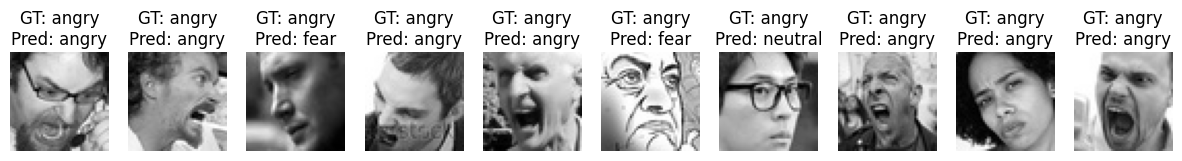

In [15]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Function to display random test images with their ground truth and predictions
def show_test_predictions(model, test_loader, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_shown = 0

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(min(num_images, len(images))):
                # Convert image tensor to numpy array
                image = images[i].cpu().squeeze().numpy()  # Convert to grayscale image

                # Get true label and prediction
                true_label = emotions[labels[i].item()]
                predicted_label = emotions[predicted[i].item()]

                # Display image
                axes[images_shown].imshow(image, cmap="gray")
                axes[images_shown].axis("off")
                axes[images_shown].set_title(f"GT: {true_label}\nPred: {predicted_label}")

                images_shown += 1
                if images_shown >= num_images:
                    plt.show()
                    return  # Stop after showing num_images

show_test_predictions(model_DeepEmotionCNN, test_loader, num_images=10)


In [16]:
# Save the trained model's parameters (weights)
torch.save(model_DeepEmotionCNN.state_dict(), "emotion_Deep_cnn_model.pth")

print("Model saved as 'emotion_Deep_cnn_model.pth'")


Model saved as 'emotion_Deep_cnn_model.pth'


The model shows promising performance with a test accuracy of 65.45%, but there is still room for improvement, particularly in distinguishing subtle emotional expressions and handling class imbalances. Addressing these challenges with data enhancement and model optimization can lead to a more accurate and reliable emotion recognition system.

**References**:

[1] Lutfiah Zahara, Purnawarman Musa, Eri Prasetyo Wibowo, and Irwan Karim, "The Facial Emotion Recognition (FER-2013) Dataset for Prediction System of Micro-Expressions Face Using the Convolutional Neural Network (CNN) Algorithm based Raspberry Pi," 2020 Fifth International Conference on Informatics and Computing (ICIC), Gorontalo, Indonesia, 2020, pp. 1-5, doi: 10.1109/ICIC50835.2020.9288560.

[2] Ali Mollahosseini, Behzad Hasani, and Mohammad H. Mahoor, "AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild," IEEE Transactions on Affective Computing, vol. 10, no. 1, pp. 18-31, Jan.-March 2019, doi: 10.1109/TAFFC.2017.2740923.

[3] P.-L. Carrier and A. Courville, "Challenges in Representation Learning: A report on three machine learning contests," 2013. [Online]. Available: https://www.kaggle.com/datasets/msambare/fer2013. [Accessed: 27-Feb-2025].

[4] A. Mollahosseini, B. Hasani, and M. H. Mahoor, "AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild," IEEE Transactions on Affective Computing, vol. 10, no. 1, pp. 18-31, Jan.-Mar. 2019. [Online]. Available: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data. [Accessed: 27-Feb-2025].